# EDA на наборі даних IAM

In [52]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
import re
from tqdm.notebook import tqdm

In [53]:
# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")

# Define paths
DATASET_ROOT = "dataset"
DATA_PATH = os.path.join(DATASET_ROOT, "iam_words/data")
MAPPINGS_PATH = "word_mappings.txt"

In [54]:
# Load word mappings
def load_word_mappings(file_path):
    mappings = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                image_path = parts[0]
                # The label might contain spaces, so we join all parts except the first one
                label = ' '.join(parts[1:])
                mappings[image_path] = label
    return mappings

In [55]:
# Load mappings
print("Завантаження маркування слів...")
word_mappings = load_word_mappings(MAPPINGS_PATH)
print(f"Завантажено {len(word_mappings)} маркованих слів")

Завантаження маркування слів...
Завантажено 114333 маркованих слів


In [56]:
# Convert mappings to DataFrame for easier analysis
df = pd.DataFrame(list(word_mappings.items()), columns=['image_path', 'word'])
df['filename'] = df['image_path'].apply(lambda x: os.path.basename(x))
df['directory'] = df['image_path'].apply(lambda x: os.path.dirname(x))

In [57]:
# Basic overview
print("\nЗагальний огляд набору даних:")
print(f"Загальна кількість прикладів: {len(df)}")
print(f"Кількість унікальних слів: {df['word'].nunique()}")


Загальний огляд набору даних:
Загальна кількість прикладів: 114333
Кількість унікальних слів: 13544


In [58]:
# Display the first few rows
print("\nПерші 5 прикладів:")
df.head()


Перші 5 прикладів:


,image_path,word,filename,directory
0,dataset/iam_words/data/a01/a01-000u/a01-000u-0...,A,a01-000u-00-00.png,dataset/iam_words/data/a01/a01-000u
1,dataset/iam_words/data/a01/a01-000u/a01-000u-0...,MOVE,a01-000u-00-01.png,dataset/iam_words/data/a01/a01-000u
2,dataset/iam_words/data/a01/a01-000u/a01-000u-0...,to,a01-000u-00-02.png,dataset/iam_words/data/a01/a01-000u
3,dataset/iam_words/data/a01/a01-000u/a01-000u-0...,stop,a01-000u-00-03.png,dataset/iam_words/data/a01/a01-000u
4,dataset/iam_words/data/a01/a01-000u/a01-000u-0...,Mr.,a01-000u-00-04.png,dataset/iam_words/data/a01/a01-000u


In [59]:
# Word length analysis
df['word_length'] = df['word'].apply(len)
print("\nWord length statistics:")
print(df['word_length'].describe())


Word length statistics:
count    114333.000000
mean          4.127951
std           2.646381
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max          53.000000
Name: word_length, dtype: float64


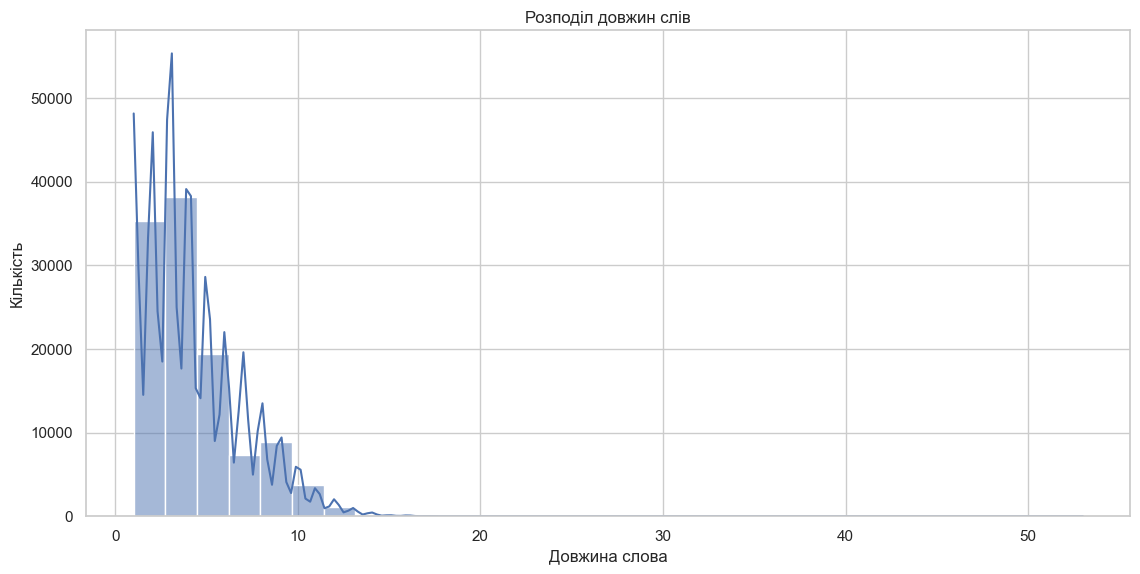

In [60]:
# Plot word length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['word_length'], bins=30, kde=True)
plt.title('Розподіл довжин слів')
plt.xlabel('Довжина слова')
plt.ylabel('Кількість')
plt.show()

In [61]:
# Найбільш поширені слова
common_words = df['word'].value_counts().head(20)
print("\nНайбільш поширені слова:\n")
print(common_words)


Найбільш поширені слова:

word
the     5758
,       5485
.       4950
of      3175
to      2600
and     2475
a       2264
in      1785
"       1599
was     1135
that    1127
is       965
he       885
'        837
for      806
with     743
I        743
had      716
it       703
his      692
Name: count, dtype: int64


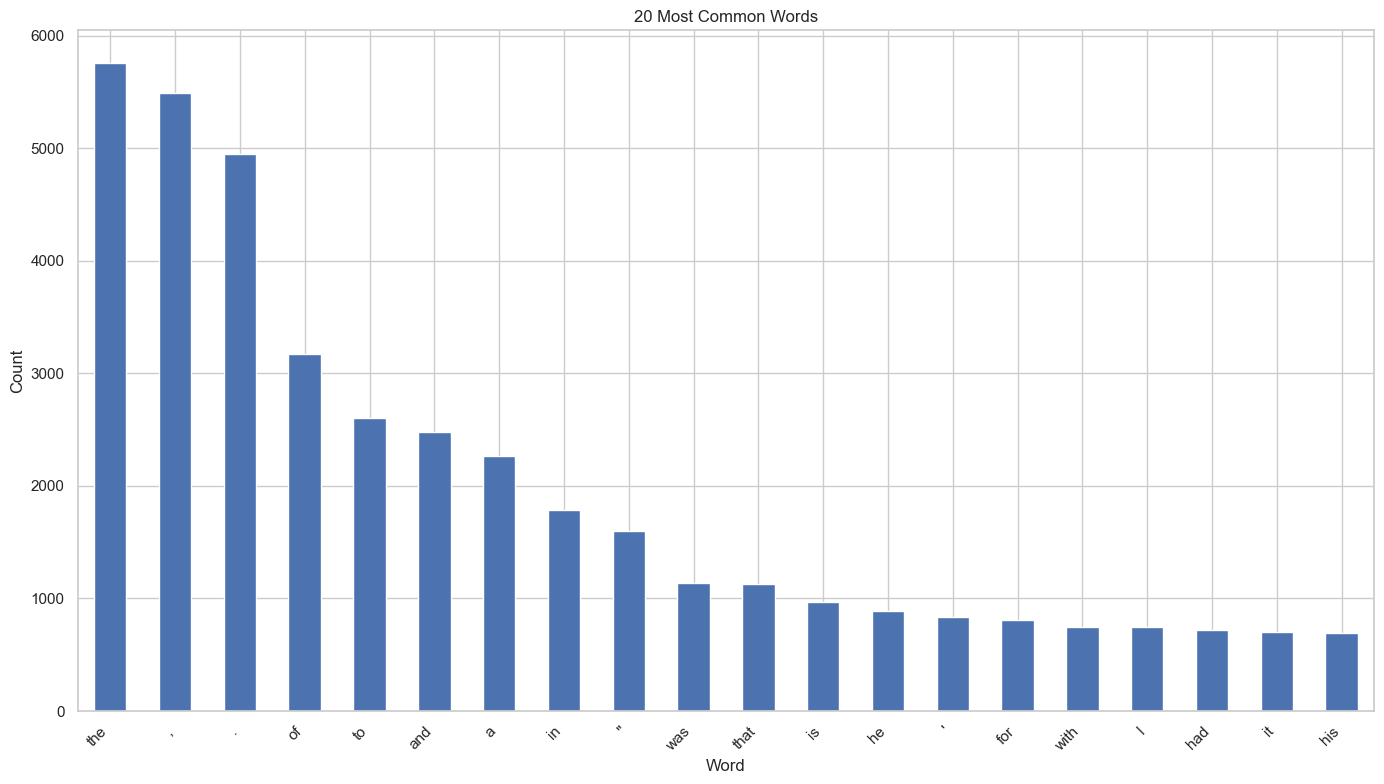

In [62]:
plt.figure(figsize=(14, 8))
common_words.plot(kind='bar')
plt.title('20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Як можна побачити найпоширенішими є прийменники, займенники, модальні та помічні дієслова

In [63]:
# Function to extract image dimensions
def get_image_dimensions(image_path):
    try:
        full_path = image_path.replace('dataset/', '')  # Adjust path if needed
        img = Image.open(full_path)
        return img.size[0], img.size[1]  # width, height
    except Exception as e:
        print(f"Помилка обробки {image_path}: {e}")
        return None, None

# Get dimensions for the sample
dimensions = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    width, height = get_image_dimensions(row['image_path'])
    if width and height:
        dimensions.append((width, height, row['word'], row['word_length'], row['image_path']))

# Create DataFrame with dimensions
dim_df = pd.DataFrame(dimensions, columns=['width', 'height', 'word', 'word_length', 'image_path'])
dim_df['aspect_ratio'] = dim_df['width'] / dim_df['height']
dim_df['area'] = dim_df['width'] * dim_df['height']
dim_df['pixels_per_char'] = dim_df['area'] / dim_df['word_length']

# Display dimension statistics
print("\nСтатистика розмірностей зображень:")
print("Статистика по ширині:")
print(dim_df['width'].describe())
print("\nСтатистика по висоті:")
print(dim_df['height'].describe())
print("\nСтатистика по співвідношенню сторін:")
print(dim_df['aspect_ratio'].describe())

  0%|          | 0/114333 [00:00<?, ?it/s]


Статистика розмірностей зображень:
Статистика по ширині:
count    114333.000000
mean        155.969248
std         116.473604
min           1.000000
25%          75.000000
50%         135.000000
75%         215.000000
max        1934.000000
Name: width, dtype: float64

Статистика по висоті:
count    114333.000000
mean         70.095992
std          33.250372
min           1.000000
25%          49.000000
50%          68.000000
75%          89.000000
max         342.000000
Name: height, dtype: float64

Статистика по співвідношенню сторін:
count    114333.000000
mean          2.219408
std           1.455036
min           0.060976
25%           1.180851
50%           1.928571
75%           2.903846
max          32.142857
Name: aspect_ratio, dtype: float64


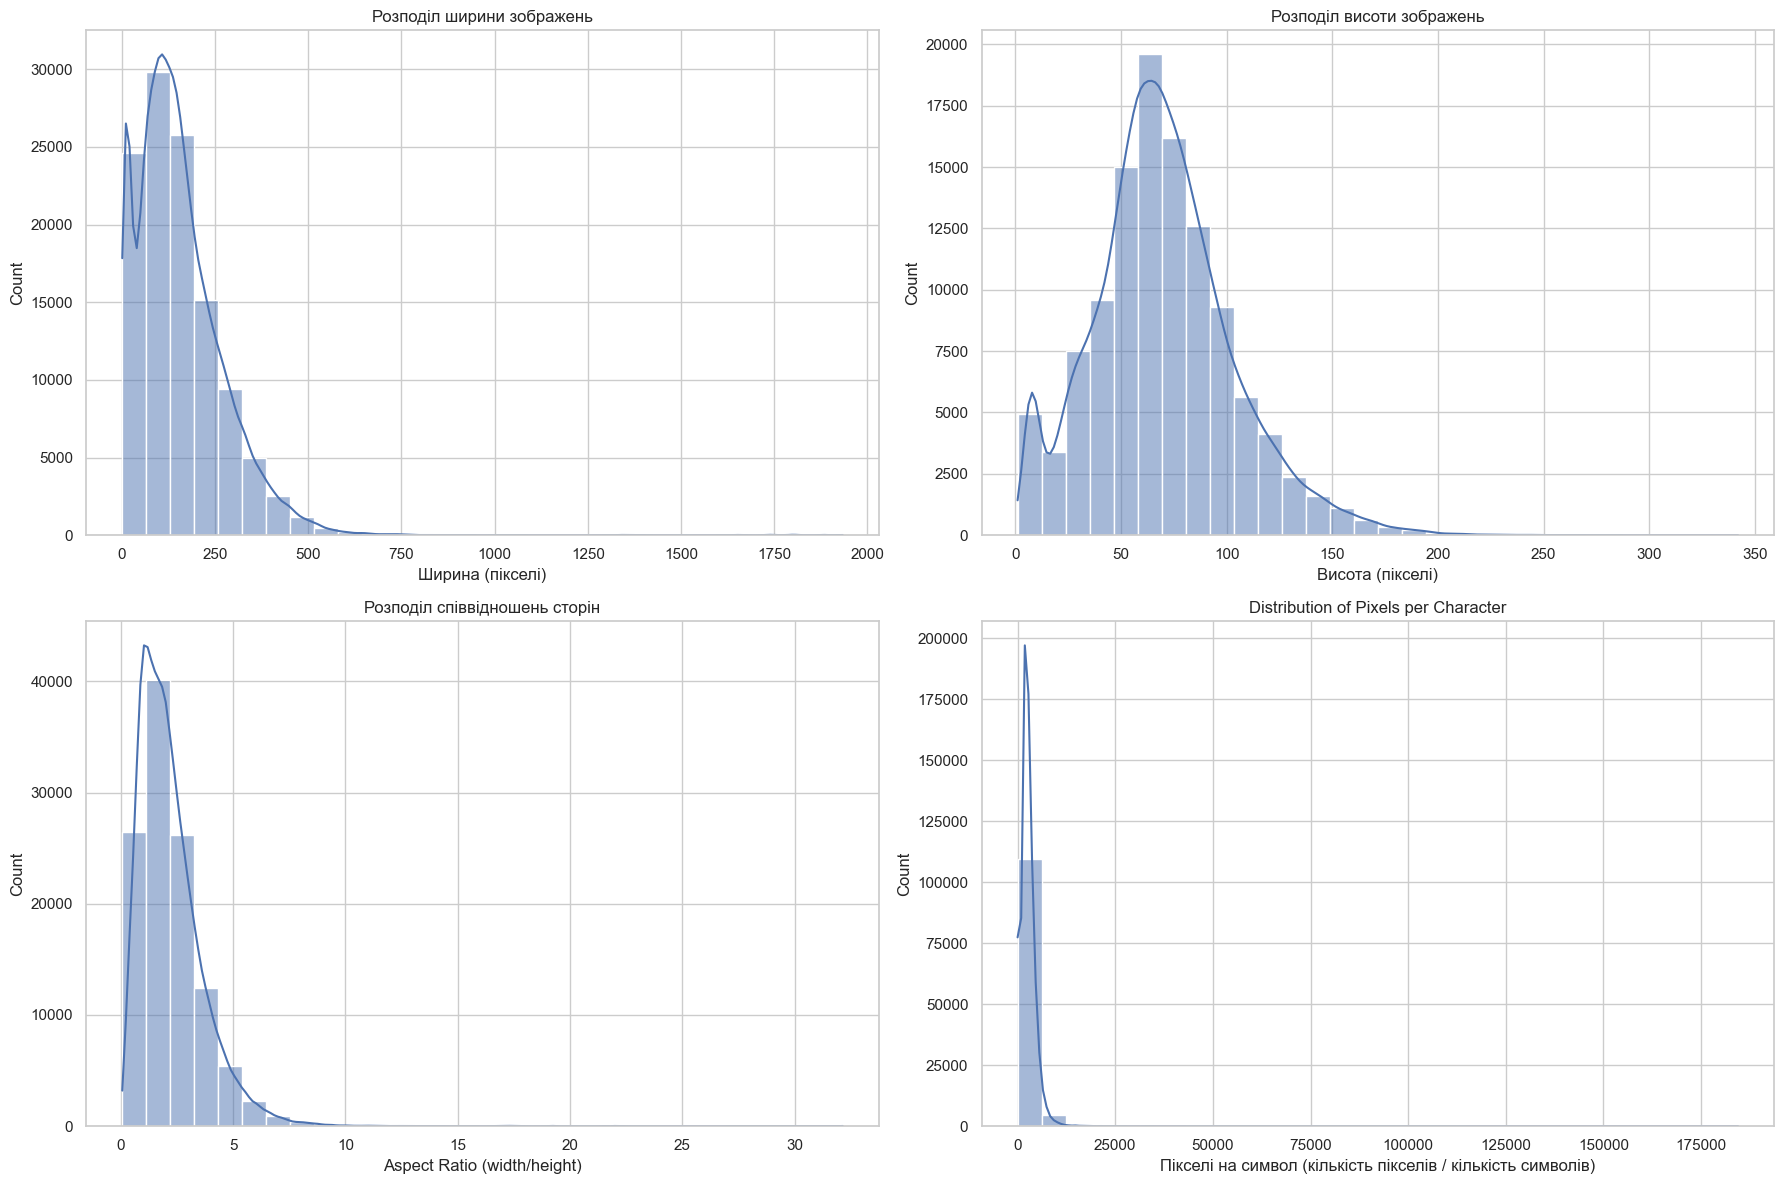

In [64]:
# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Width distribution
sns.histplot(dim_df['width'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Розподіл ширини зображень')
axes[0, 0].set_xlabel('Ширина (пікселі)')

# Height distribution
sns.histplot(dim_df['height'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Розподіл висоти зображень')
axes[0, 1].set_xlabel('Висота (пікселі)')

# Aspect ratio distribution
sns.histplot(dim_df['aspect_ratio'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Розподіл співвідношень сторін')
axes[1, 0].set_xlabel('Aspect Ratio (width/height)')

# Pixels per character
sns.histplot(dim_df['pixels_per_char'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Pixels per Character')
axes[1, 1].set_xlabel('Пікселі на символ (кількість пікселів / кількість символів)')

plt.tight_layout()
plt.show()

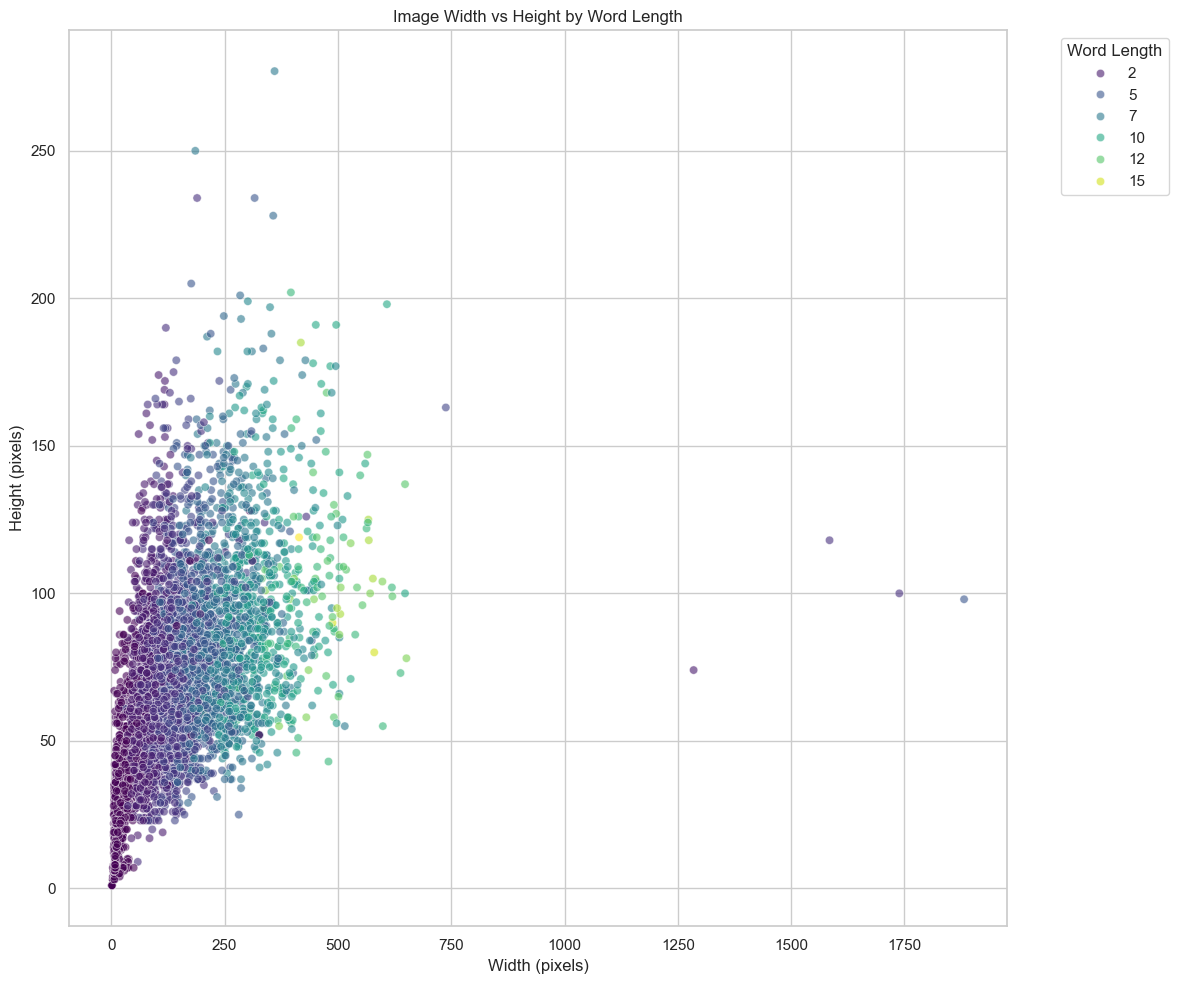

In [34]:
# Scatter plot of width vs height
plt.figure(figsize=(12, 10))
sns.scatterplot(data=dim_df, x='width', y='height', hue='word_length', palette='viridis', alpha=0.6)
plt.title('Image Width vs Height by Word Length')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.legend(title='Word Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

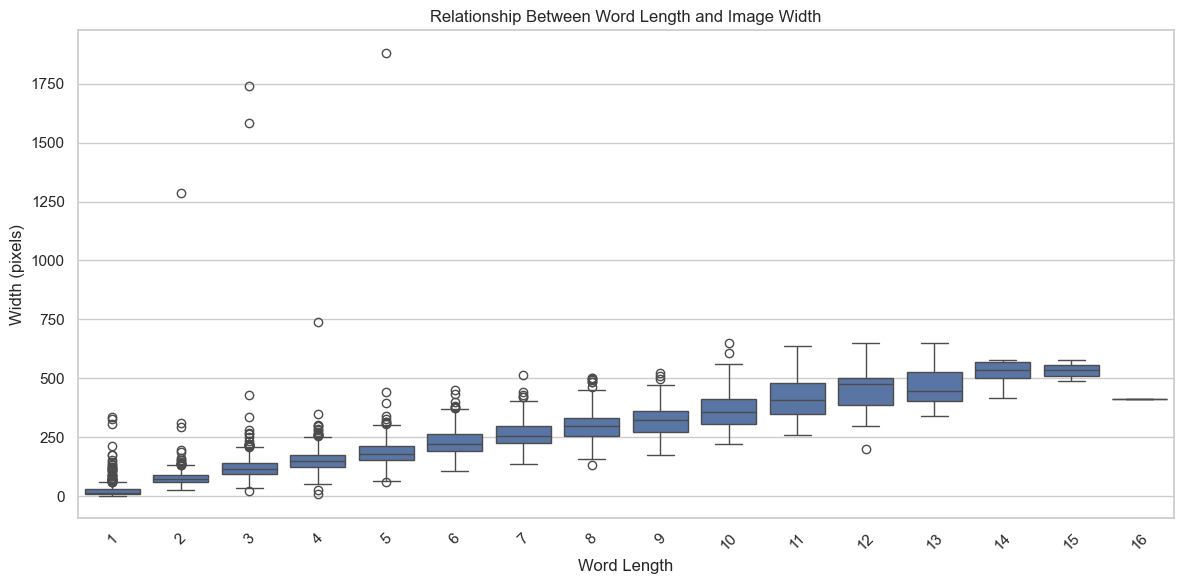

In [33]:
# Relationship between word length and image width
plt.figure(figsize=(12, 6))
sns.boxplot(data=dim_df, x='word_length', y='width')
plt.title('Relationship Between Word Length and Image Width')
plt.xlabel('Word Length')
plt.ylabel('Width (pixels)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# Detect potential anomalies

# 1. Images with extreme aspect ratios
aspect_ratio_threshold_high = dim_df['aspect_ratio'].quantile(0.975)
aspect_ratio_threshold_low = dim_df['aspect_ratio'].quantile(0.025)
extreme_aspect_ratio = dim_df[(dim_df['aspect_ratio'] > aspect_ratio_threshold_high) | 
                              (dim_df['aspect_ratio'] < aspect_ratio_threshold_low)]

print("\nPotential anomalies - Extreme aspect ratios:")
print(extreme_aspect_ratio[['image_path', 'width', 'height', 'aspect_ratio', 'word']])


Potential anomalies - Extreme aspect ratios:
                                               image_path  width  height  \
16      dataset/iam_words/data/a01/a01-000u/a01-000u-0...    281      46   
23      dataset/iam_words/data/a01/a01-000u/a01-000u-0...    431      54   
32      dataset/iam_words/data/a01/a01-000u/a01-000u-0...    428      54   
41      dataset/iam_words/data/a01/a01-000u/a01-000u-0...    310      51   
49      dataset/iam_words/data/a01/a01-000u/a01-000u-0...    441      59   
...                                                   ...    ...     ...   
114285  dataset/iam_words/data/r06/r06-143/r06-143-00-...     22      66   
114304  dataset/iam_words/data/r06/r06-143/r06-143-02-...      9      31   
114307  dataset/iam_words/data/r06/r06-143/r06-143-02-...     26      70   
114311  dataset/iam_words/data/r06/r06-143/r06-143-03-...      8      64   
114313  dataset/iam_words/data/r06/r06-143/r06-143-03-...     23      69   

        aspect_ratio        word  
16    

In [66]:
# 2. Unusually large or small images
area_threshold_high = dim_df['area'].quantile(0.975)
area_threshold_low = dim_df['area'].quantile(0.025)
extreme_area = dim_df[(dim_df['area'] > area_threshold_high) | 
                      (dim_df['area'] < area_threshold_low)]

print("\nPotential anomalies - Extreme image sizes:")
print(extreme_area[['image_path', 'width', 'height', 'area', 'word']])


Potential anomalies - Extreme image sizes:
                                               image_path  width  height  \
124     dataset/iam_words/data/a01/a01-003/a01-003-02-...    499     115   
126     dataset/iam_words/data/a01/a01-003/a01-003-02-...      7       7   
154     dataset/iam_words/data/a01/a01-003/a01-003-06-...      8       8   
184     dataset/iam_words/data/a01/a01-003/a01-003-10-...      7       8   
190     dataset/iam_words/data/a01/a01-003u/a01-003u-0...    462     106   
...                                                   ...    ...     ...   
114230  dataset/iam_words/data/r06/r06-137/r06-137-06-...    432     124   
114241  dataset/iam_words/data/r06/r06-137/r06-137-07-...      9       6   
114290  dataset/iam_words/data/r06/r06-143/r06-143-01-...      7       6   
114310  dataset/iam_words/data/r06/r06-143/r06-143-02-...      7       8   
114318  dataset/iam_words/data/r06/r06-143/r06-143-03-...      8       7   

         area            word  
124     573

In [67]:
# 3. Disproportionate pixel-to-character ratio
pixels_per_char_high = dim_df['pixels_per_char'].quantile(0.975)
pixels_per_char_low = dim_df['pixels_per_char'].quantile(0.025)
extreme_pixel_ratio = dim_df[(dim_df['pixels_per_char'] > pixels_per_char_high) | 
                             (dim_df['pixels_per_char'] < pixels_per_char_low)]

print("\nPotential anomalies - Extreme pixels per character:")
print(extreme_pixel_ratio[['image_path', 'word', 'word_length', 'area', 'pixels_per_char']])



Potential anomalies - Extreme pixels per character:
                                               image_path word  word_length  \
25      dataset/iam_words/data/a01/a01-000u/a01-000u-0...  Mr.            3   
126     dataset/iam_words/data/a01/a01-003/a01-003-02-...    .            1   
151     dataset/iam_words/data/a01/a01-003/a01-003-06-...  put            3   
154     dataset/iam_words/data/a01/a01-003/a01-003-06-...    .            1   
160     dataset/iam_words/data/a01/a01-003/a01-003-07-...   of            2   
...                                                   ...  ...          ...   
114241  dataset/iam_words/data/r06/r06-137/r06-137-07-...    .            1   
114288  dataset/iam_words/data/r06/r06-143/r06-143-01-...    #            1   
114290  dataset/iam_words/data/r06/r06-143/r06-143-01-...    .            1   
114310  dataset/iam_words/data/r06/r06-143/r06-143-02-...    .            1   
114318  dataset/iam_words/data/r06/r06-143/r06-143-03-...    .            1   

In [40]:
# Function to display some anomalous examples
def display_examples(dataframe, n=5):
    """Display n random examples from the dataframe"""
    sample = dataframe.sample(min(n, len(dataframe)))
    
    fig, axes = plt.subplots(1, len(sample), figsize=(15, 5))
    if len(sample) == 1:
        axes = [axes]  # Convert to list for single image case
        
    for i, (_, row) in enumerate(sample.iterrows()):
        try:
            img_path = row['image_path'].replace('dataset/', '')
            img = Image.open(img_path)
            axes[i].imshow(np.array(img), cmap='gray')
            axes[i].set_title(f"Word: '{row['word']}'\nW: {row['width']}, H: {row['height']}")
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error: {e}", ha='center', va='center')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


Displaying examples of extreme aspect ratio images:


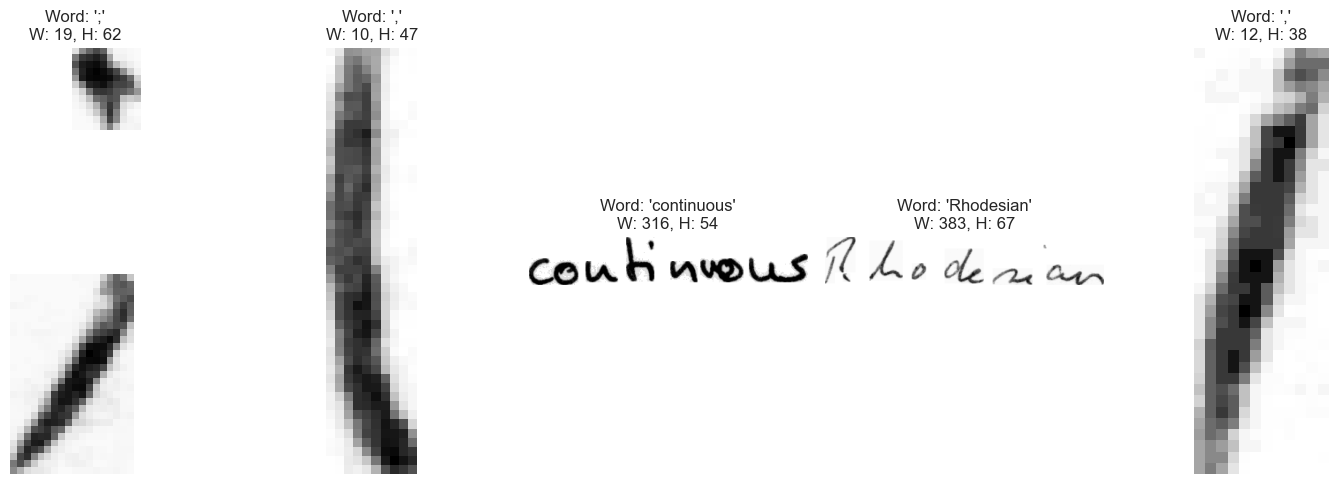

In [41]:
# Display examples of anomalies
print("\nDisplaying examples of extreme aspect ratio images:")
display_examples(extreme_aspect_ratio)


Displaying examples of extreme size images:


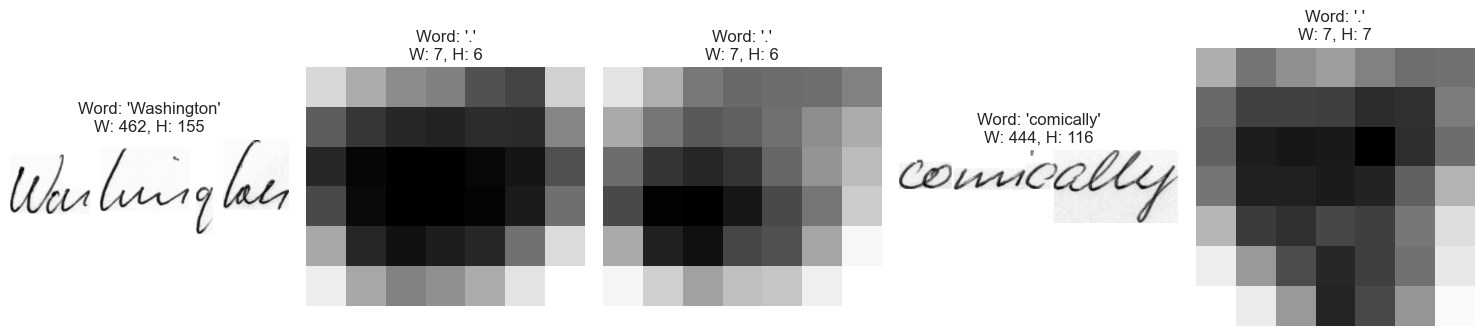

In [42]:
print("\nDisplaying examples of extreme size images:")
display_examples(extreme_area)


Displaying examples of extreme pixel-per-character ratio images:


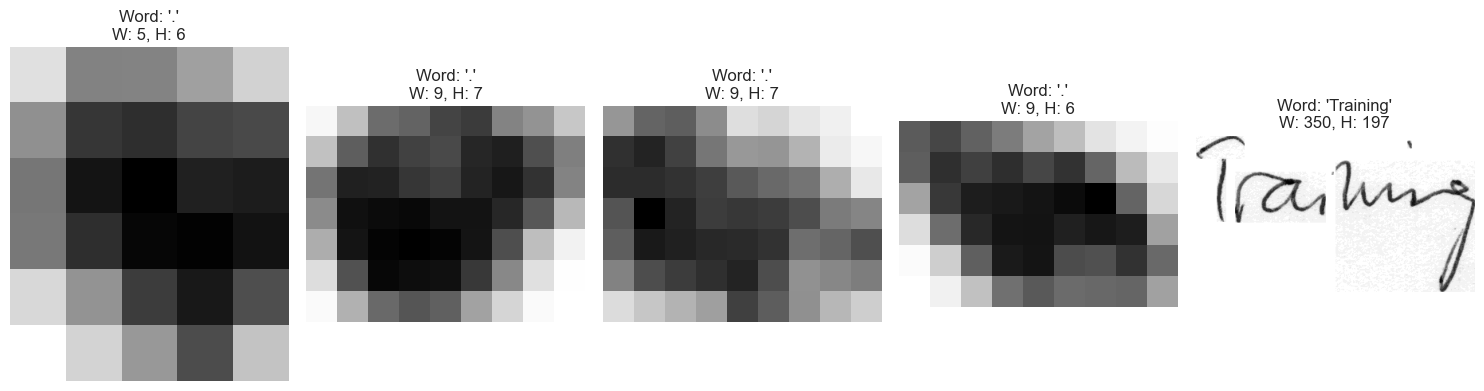

In [43]:
print("\nDisplaying examples of extreme pixel-per-character ratio images:")
display_examples(extreme_pixel_ratio)

In [47]:
# Summary of findings
print("\n=== SUMMARY OF FINDINGS ===")
print(f"Total analyzed samples: {len(dim_df)}")
print(f"Image width range: {dim_df['width'].min()} to {dim_df['width'].max()} pixels")
print(f"Image height range: {dim_df['height'].min()} to {dim_df['height'].max()} pixels")
print(f"Aspect ratio range: {dim_df['aspect_ratio'].min():.2f} to {dim_df['aspect_ratio'].max():.2f}")
print(f"Word length range: {dim_df['word_length'].min()} to {dim_df['word_length'].max()} characters")

print("\nPotential anomalies:")
print(f"- {len(extreme_aspect_ratio)} images with extreme aspect ratios")
print(f"- {len(extreme_area)} images with extreme sizes")
print(f"- {len(extreme_pixel_ratio)} images with unusual pixel-to-character ratios")


=== SUMMARY OF FINDINGS ===
Total analyzed samples: 5000
Image width range: 1 to 1882 pixels
Image height range: 1 to 277 pixels
Aspect ratio range: 0.09 to 19.20
Word length range: 1 to 16 characters

Potential anomalies:
- 250 images with extreme aspect ratios
- 247 images with extreme sizes
- 248 images with unusual pixel-to-character ratios


In [138]:
print("\n" + "="*80)
print("ВИЯВЛЕННЯ АНОМАЛЬНИХ ЗОБРАЖЕНЬ З ВЕЛИКОЮ ШИРИНОЮ І МАЛОЮ ВИСОТОЮ")
print("="*80)

# Define criteria for suspicious images
def is_suspicious(width, height, word_length):
    """
    Визначити зображення з підозріло великою шириною та малою висотою відносно довжини слова
    """
    # Images with very high width and small height are likely mislabeled
    width_height_ratio = width / max(height, 1)  # Уникаємо ділення на нуль
    
    # Перевіряємо декілька підозрілих умов
    conditions = [
        width > 800 
    ]
    
    return any(conditions)

# Find suspicious images
suspicious_images = []

print("Аналіз набору даних на наявність підозрілих зображень...")
for idx, row in tqdm(dim_df.iterrows(), total=len(dim_df)):
    if is_suspicious(row['width'], row['height'], row['word_length']):
        suspicious_images.append({
            'image_path': row['image_path'],
            'word': row['word'],
            'width': row['width'],
            'height': row['height'],
            'aspect_ratio': row['aspect_ratio'],
            'word_length': row['word_length']
        })

# Create DataFrame with suspicious images
suspicious_df = pd.DataFrame(suspicious_images)

# Display summary
print(f"\nЗнайдено {len(suspicious_df)} підозрілих зображень з екстремальними розмірами.")


ВИЯВЛЕННЯ АНОМАЛЬНИХ ЗОБРАЖЕНЬ З ВЕЛИКОЮ ШИРИНОЮ І МАЛОЮ ВИСОТОЮ
Аналіз набору даних на наявність підозрілих зображень...


  0%|          | 0/114333 [00:00<?, ?it/s]


Знайдено 90 підозрілих зображень з екстремальними розмірами.



Статистика підозрілих зображень:
Середня ширина: 1380.90 пікселів
Середня висота: 111.41 пікселів
Середнє співвідношення сторін: 14.58
Медіанна довжина слова: 6.0

Найбільш підозрілі зображення (найбільше співвідношення ширини до висоти):


,image_path,word,width,height,aspect_ratio,word_length,form_sequence
71,dataset/iam_words/data/m02/m02-083/m02-083-11-...,Panama,1800,56,32.142857,6,m02/m02-083
68,dataset/iam_words/data/m02/m02-083/m02-083-11-...,contingent,1800,56,32.142857,10,m02/m02-083
67,dataset/iam_words/data/m02/m02-083/m02-083-11-...,O.G.O.,1800,56,32.142857,6,m02/m02-083
70,dataset/iam_words/data/m02/m02-083/m02-083-11-...,the,1800,56,32.142857,3,m02/m02-083
69,dataset/iam_words/data/m02/m02-083/m02-083-11-...,in,1800,56,32.142857,2,m02/m02-083
66,dataset/iam_words/data/m02/m02-083/m02-083-11-...,the,1800,57,31.578947,3,m02/m02-083
73,dataset/iam_words/data/m04/m04-081/m04-081-10-...,",",1207,50,24.140000,1,m04/m04-081
36,dataset/iam_words/data/d06/d06-063/d06-063-10-...,England,1676,75,22.346667,7,d06/d06-063
31,dataset/iam_words/data/d06/d06-063/d06-063-10-...,happening,1651,75,22.013333,9,d06/d06-063
35,dataset/iam_words/data/d06/d06-063/d06-063-10-...,of,1651,75,22.013333,2,d06/d06-063



Приклади підозрілих зображень:


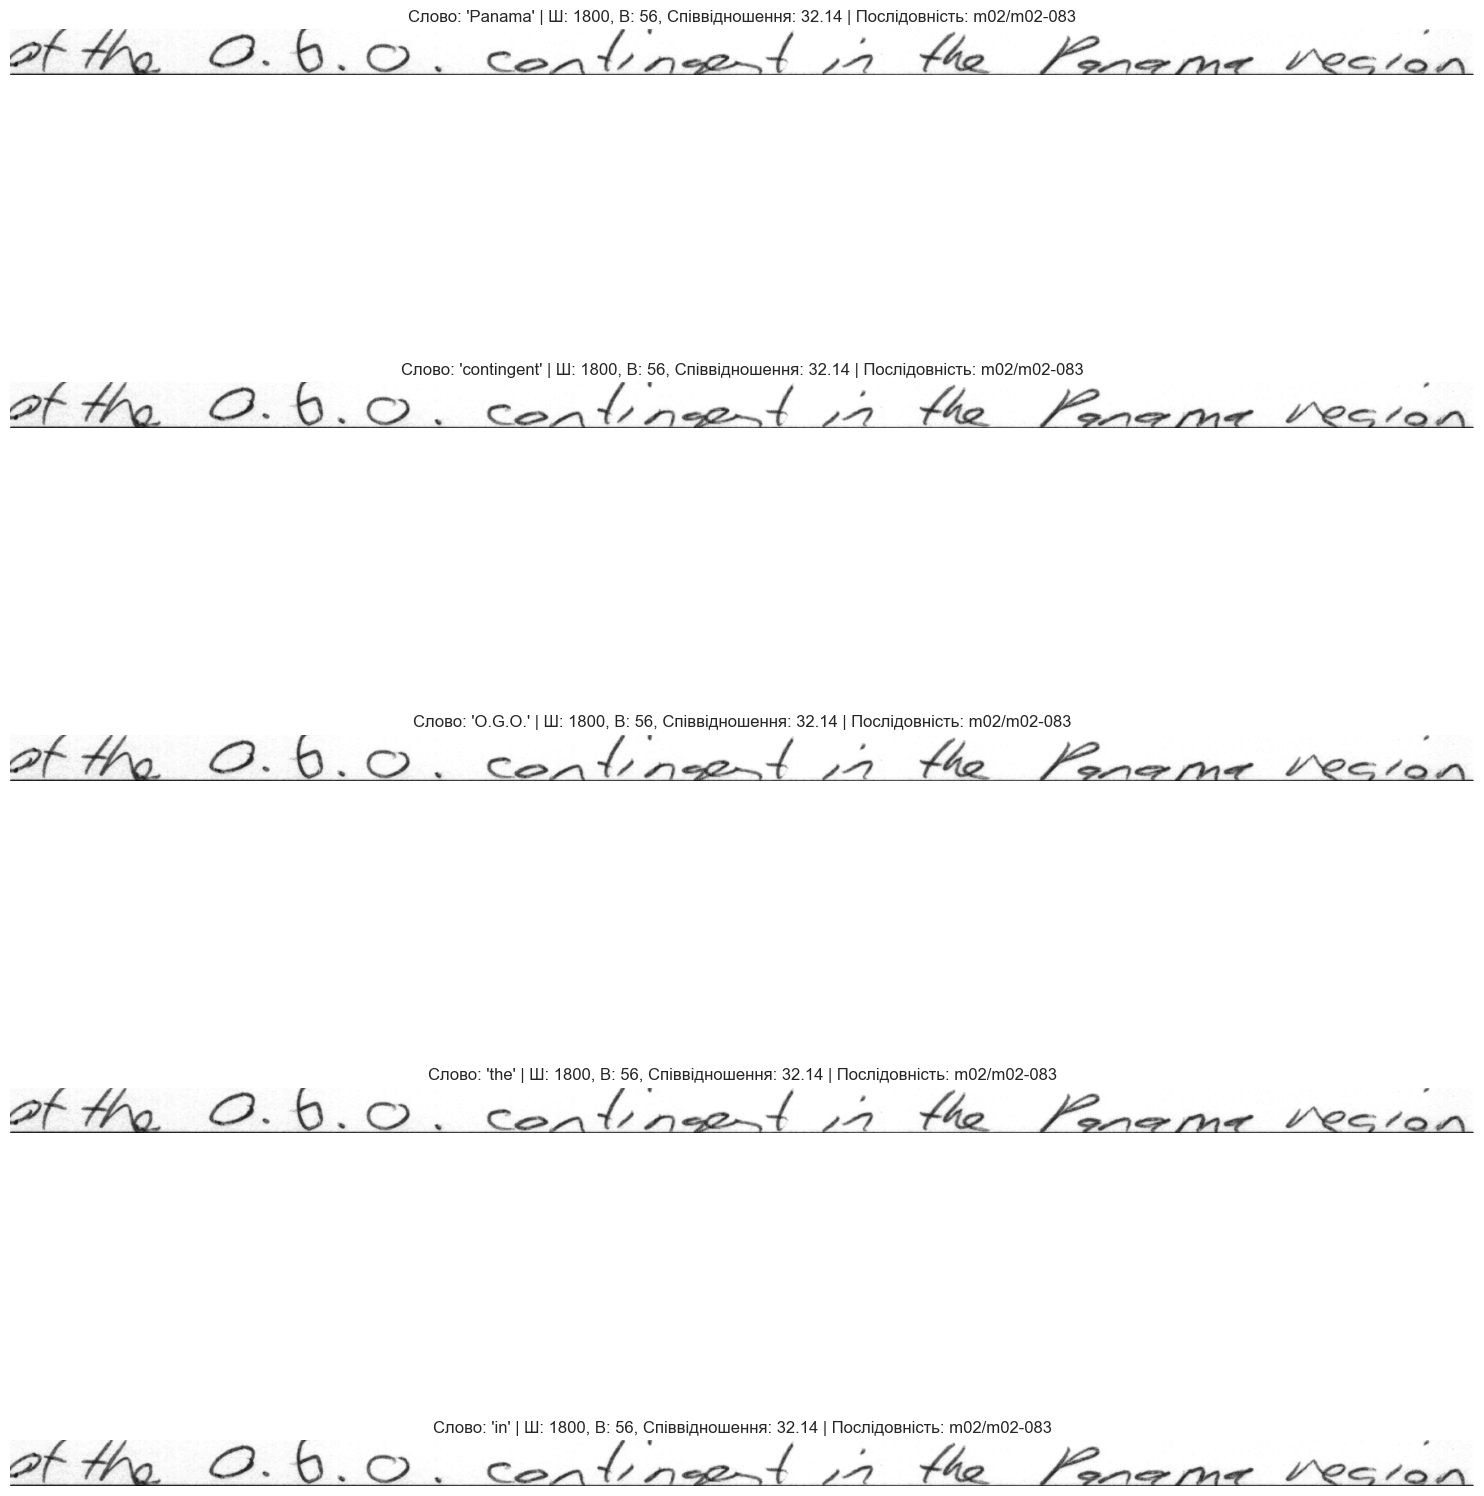


Пошук повних послідовностей для підозрілих зображень...
Знайдено 43 унікальних послідовностей з підозрілими зображеннями
Загальна кількість зображень у підозрілих послідовностях: 3526

Приклади повних послідовностей, що містять підозрілі зображення:

Послідовність: m02/m02-083 (Кількість зображень: 116)


,image_path,word
0,dataset/iam_words/data/m02/m02-083/m02-083-00-...,Peron
1,dataset/iam_words/data/m02/m02-083/m02-083-00-...,entered
2,dataset/iam_words/data/m02/m02-083/m02-083-00-...,","
3,dataset/iam_words/data/m02/m02-083/m02-083-00-...,a
4,dataset/iam_words/data/m02/m02-083/m02-083-00-...,large
5,dataset/iam_words/data/m02/m02-083/m02-083-00-...,man
6,dataset/iam_words/data/m02/m02-083/m02-083-00-...,","
7,dataset/iam_words/data/m02/m02-083/m02-083-00-...,who
8,dataset/iam_words/data/m02/m02-083/m02-083-00-...,had
9,dataset/iam_words/data/m02/m02-083/m02-083-00-...,once


... і ще 106 зображень

Послідовність: m04/m04-081 (Кількість зображень: 96)


,image_path,word
0,dataset/iam_words/data/m04/m04-081/m04-081-00-...,Where
1,dataset/iam_words/data/m04/m04-081/m04-081-00-...,indeed
2,dataset/iam_words/data/m04/m04-081/m04-081-00-...,?
3,dataset/iam_words/data/m04/m04-081/m04-081-00-...,Megan
4,dataset/iam_words/data/m04/m04-081/m04-081-00-...,Thomas
5,dataset/iam_words/data/m04/m04-081/m04-081-00-...,spoke
6,dataset/iam_words/data/m04/m04-081/m04-081-00-...,sharply
7,dataset/iam_words/data/m04/m04-081/m04-081-01-...,to
8,dataset/iam_words/data/m04/m04-081/m04-081-01-...,the
9,dataset/iam_words/data/m04/m04-081/m04-081-01-...,conductor


... і ще 86 зображень

Послідовність: d06/d06-063 (Кількість зображень: 93)


,image_path,word
0,dataset/iam_words/data/d06/d06-063/d06-063-00-...,In
1,dataset/iam_words/data/d06/d06-063/d06-063-00-...,the
2,dataset/iam_words/data/d06/d06-063/d06-063-00-...,days
3,dataset/iam_words/data/d06/d06-063/d06-063-00-...,when
4,dataset/iam_words/data/d06/d06-063/d06-063-00-...,most
5,dataset/iam_words/data/d06/d06-063/d06-063-00-...,people
6,dataset/iam_words/data/d06/d06-063/d06-063-00-...,were
7,dataset/iam_words/data/d06/d06-063/d06-063-00-...,born
8,dataset/iam_words/data/d06/d06-063/d06-063-00-...,","
9,dataset/iam_words/data/d06/d06-063/d06-063-01-...,lived


... і ще 83 зображень

Зберігаємо інформацію про підозрілі послідовності у файл: suspicious_sequences.txt
Записано 3526 зображень з 43 підозрілих послідовностей у файл.
Також записано 90 підозрілих зображень у окремий файл: suspicious_images.txt


In [140]:
if len(suspicious_df) > 0:
    # Display some statistics about suspicious images
    print("\nСтатистика підозрілих зображень:")
    print(f"Середня ширина: {suspicious_df['width'].mean():.2f} пікселів")
    print(f"Середня висота: {suspicious_df['height'].mean():.2f} пікселів")
    print(f"Середнє співвідношення сторін: {suspicious_df['aspect_ratio'].mean():.2f}")
    print(f"Медіанна довжина слова: {suspicious_df['word_length'].median()}")
    
    # Sort by aspect ratio (most extreme first)
    suspicious_df = suspicious_df.sort_values(by='aspect_ratio', ascending=False)
    
    # Extract form sequence prefix from image path
    def extract_form_sequence(image_path):
        # Extract pattern like "m02-083" from "dataset/iam_words/data/m02/m02-083/m02-083-11-00.png"
        match = re.search(r'/([a-z]\d+/[a-z]\d+-\d+)/', image_path)
        if match:
            return match.group(1)
        # Fallback: extract just the directory
        dirs = image_path.split('/')
        if len(dirs) >= 4:
            return f"{dirs[-3]}/{dirs[-2]}"
        return None
    
    suspicious_df['form_sequence'] = suspicious_df['image_path'].apply(extract_form_sequence)
    
    # Display the most extreme examples
    print("\nНайбільш підозрілі зображення (найбільше співвідношення ширини до висоти):")
    display(suspicious_df.head(10)[['image_path', 'word', 'width', 'height', 'aspect_ratio', 'word_length', 'form_sequence']])
    
    # Plot a few examples of the suspicious images
    print("\nПриклади підозрілих зображень:")
    
    # Function to display suspicious image examples
    def display_suspicious_examples(examples_df, n=5):
        """Display n examples from the suspicious images dataframe"""
        sample = examples_df.head(min(n, len(examples_df)))
        
        fig, axes = plt.subplots(len(sample), 1, figsize=(15, 4*len(sample)))
        if len(sample) == 1:
            axes = [axes]  # Convert to list for single image case
            
        for i, (_, row) in enumerate(sample.iterrows()):
            try:
                img_path = row['image_path'].replace('dataset/', '')
                img = Image.open(img_path)
                axes[i].imshow(np.array(img), cmap='gray')
                axes[i].set_title(f"Слово: '{row['word']}' | Ш: {row['width']}, В: {row['height']}, " +
                                 f"Співвідношення: {row['aspect_ratio']:.2f} | Послідовність: {row['form_sequence']}")
                axes[i].axis('off')
            except Exception as e:
                axes[i].text(0.5, 0.5, f"Помилка: {e}", ha='center', va='center')
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Display examples
    display_suspicious_examples(suspicious_df)
    
    # Find all image paths from the same form sequences as suspicious images
    print("\nПошук повних послідовностей для підозрілих зображень...")
    
    # Get all unique form sequences containing suspicious images
    suspicious_sequences = suspicious_df['form_sequence'].unique()
    print(f"Знайдено {len(suspicious_sequences)} унікальних послідовностей з підозрілими зображеннями")
    
    # For each suspicious sequence, find all images in that sequence
    all_df = df.copy()  # Working with the original full dataframe
    all_df['form_sequence'] = all_df['image_path'].apply(extract_form_sequence)
    
    # Get all images that are part of suspicious sequences
    sequence_images = all_df[all_df['form_sequence'].isin(suspicious_sequences)]
    sequence_images = sequence_images.sort_values(by=['form_sequence', 'image_path'])
    
    print(f"Загальна кількість зображень у підозрілих послідовностях: {len(sequence_images)}")
    
    # Display some examples of complete sequences
    print("\nПриклади повних послідовностей, що містять підозрілі зображення:")
    for seq in suspicious_sequences[:3]:  # Show first 3 sequences
        seq_images = sequence_images[sequence_images['form_sequence'] == seq]
        print(f"\nПослідовність: {seq} (Кількість зображень: {len(seq_images)})")
        display(seq_images[['image_path', 'word']].reset_index(drop=True).head(10))
        if len(seq_images) > 10:
            print(f"... і ще {len(seq_images) - 10} зображень")
    
    # Save suspicious sequences to file
    suspicious_file = "suspicious_sequences.txt"
    print(f"\nЗберігаємо інформацію про підозрілі послідовності у файл: {suspicious_file}")
    
    with open(suspicious_file, 'w', encoding='utf-8') as f:
        f.write("# Підозрілі послідовності зображень з аномальними розмірами\n")
        f.write("# формат: шлях_до_зображення\tслово [ш=ширина, в=висота, с=співвідношення]\n\n")
        
        # Group by form sequence
        for seq in suspicious_sequences:
            seq_images = sequence_images[sequence_images['form_sequence'] == seq]
            f.write(f"# Послідовність: {seq}\n")
            
            # Write all images in the sequence
            for _, row in seq_images.iterrows():
                # Check if we have dimension info for this image
                dim_row = dim_df[dim_df['image_path'] == row['image_path']]
                if len(dim_row) > 0:
                    width = dim_row['width'].values[0]
                    height = dim_row['height'].values[0]
                    aspect = dim_row['aspect_ratio'].values[0]
                    is_susp = "ПІДОЗРІЛЕ" if row['image_path'] in suspicious_df['image_path'].values else ""
                    f.write(f"{row['image_path']}\t{row['word']} [ш={width}, в={height}, с={aspect:.2f}] {is_susp}\n")
                else:
                    f.write(f"{row['image_path']}\t{row['word']}\n")
            
            f.write("\n")  # Empty line between sequences
    
    print(f"Записано {len(sequence_images)} зображень з {len(suspicious_sequences)} підозрілих послідовностей у файл.")
    
    # Also save just the suspicious images
    suspicious_only_file = "suspicious_images.txt"
    with open(suspicious_only_file, 'w', encoding='utf-8') as f:
        f.write("# Підозрілі зображення з аномальними розмірами\n")
        f.write("# формат: шлях_до_зображення\tслово [ш=ширина, в=висота, с=співвідношення]\n\n")
        
        for _, row in suspicious_df.iterrows():
            f.write(f"{row['image_path']}\t{row['word']} [ш={row['width']}, в={row['height']}, "
                   f"с={row['aspect_ratio']:.2f}]\n")
    
    print(f"Також записано {len(suspicious_df)} підозрілих зображень у окремий файл: {suspicious_only_file}")
else:
    print("Підозрілих зображень не знайдено.")